# Testing removing velocity artifacts with A11 winter data

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:53:03 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:53:03 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:53:03 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
with open('../chirp_processing/A11_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

In [3]:
def strain_metrics(ds, win_cor, step, lag, noise_floor):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_adjust = vv - vv.where(vv.profile_range<50).where(vv.profile_range > 30).mean(dim='profile_range')
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    vv_mean_err = (vv_err.where(vv.profile_range<50).where(vv.profile_range > 30)**2).sum(dim='profile_range')/len(vv_err.profile_range.where(vv.profile_range<50,drop=True).where(vv.profile_range > 30,drop=True))
    vv_adjust_err = np.sqrt(vv_err**2 + vv_mean_err**2)

    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    int_err = slope_errs*np.sqrt(((vv.profile_range)**2).sum()/len(vv.profile_range))
    ds = vv.to_dataset(name='vv')
    ds['err'] = vv_err
    ds['slope']= fit.polyfit_coefficients.sel(degree=1)
    ds['intercept']=fit.polyfit_coefficients.sel(degree=0)
    ds['fit'] = slope
    ds['slope_err'] = slope_errs
    ds['int_err'] = int_err
    ds['vv_adjust'] = vv_adjust
    ds['vv_adjust_err'] = vv_adjust_err
    ds['doy_decimal'] =  ds.time.dt.dayofyear + (ds.time.dt.hour / 24) + (ds.time.dt.minute / 1440) + (ds.time.dt.second / 86400)
    return ds

def plot_fits(ds_15,ds_hour,xlims=False):
    fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
    axs[0].errorbar(ds_15.doy_decimal,ds_15.slope,yerr=ds_15.slope_err,marker='.',ecolor='k',label = '15 minute')
    axs[0].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='r',label = '1 hour')
    axs[0].legend()
    if xlims:
        axs[0].set_xlim(xlims)
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain rate estimates')
    
    axs[1].errorbar(ds_15.doy_decimal,ds_15.intercept,yerr=ds_15.int_err,marker='.',ecolor='k',label = '15 minute intercept')
    axs[1].errorbar(ds_hour.doy_decimal,ds_hour.intercept,yerr=ds_hour.int_err,marker='.',ecolor='r',label = '1 hour intercept')
    axs[1].plot(ds_15.doy_decimal,ds_15.vv.where(ds_15.profile_range<100).mean(dim='profile_range'),linestyle='None',marker='.',label='15 minute mean vv')
    axs[1].plot(ds_hour.doy_decimal,ds_hour.vv.where(ds_hour.profile_range<100).mean(dim='profile_range'),linestyle='None',marker='.',label='1 hour mean vv')
    axs[1].legend()
    axs[1].set_title('Strain-fitting intercept and mean top-100 m vertical velocities')
    axs[1].set_ylabel('velocity [m y$^{-1}$]')
    axs[1].set_xlabel('DOY 2022')

def convert_to_doy(da):
    da['doy_decimal'] = da.time.dt.dayofyear + (da.time.dt.hour / 24) + (da.time.dt.minute / 1440) + (da.time.dt.second / 86400)
    return da

def plot_vv_2d(ds,xlims=None):

    fig, axs = plt.subplots(figsize=(20,10),nrows=2,sharex=True)
    plt1 = ds.vv.plot(ax=axs[0],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[0].invert_yaxis()
    axs[0].set_title('Vertical velocity estimate')
    axs[0].set_xlabel('')
    plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

    plt2 = ds.vv_adjust.plot(ax=axs[1],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[1].invert_yaxis()
    axs[1].set_xlabel('Date')
    axs[1].set_title('Vertical velocity with adjustment')
    if xlims:
        plt.xlim(xlims)
    plt2.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



In [4]:
time_to_interp = pd.date_range("2022-09-25 16:00", "2023-05-22 12:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')

In [5]:
a11_winter = strain_metrics(interp_profiles, 70, 70,96,600)

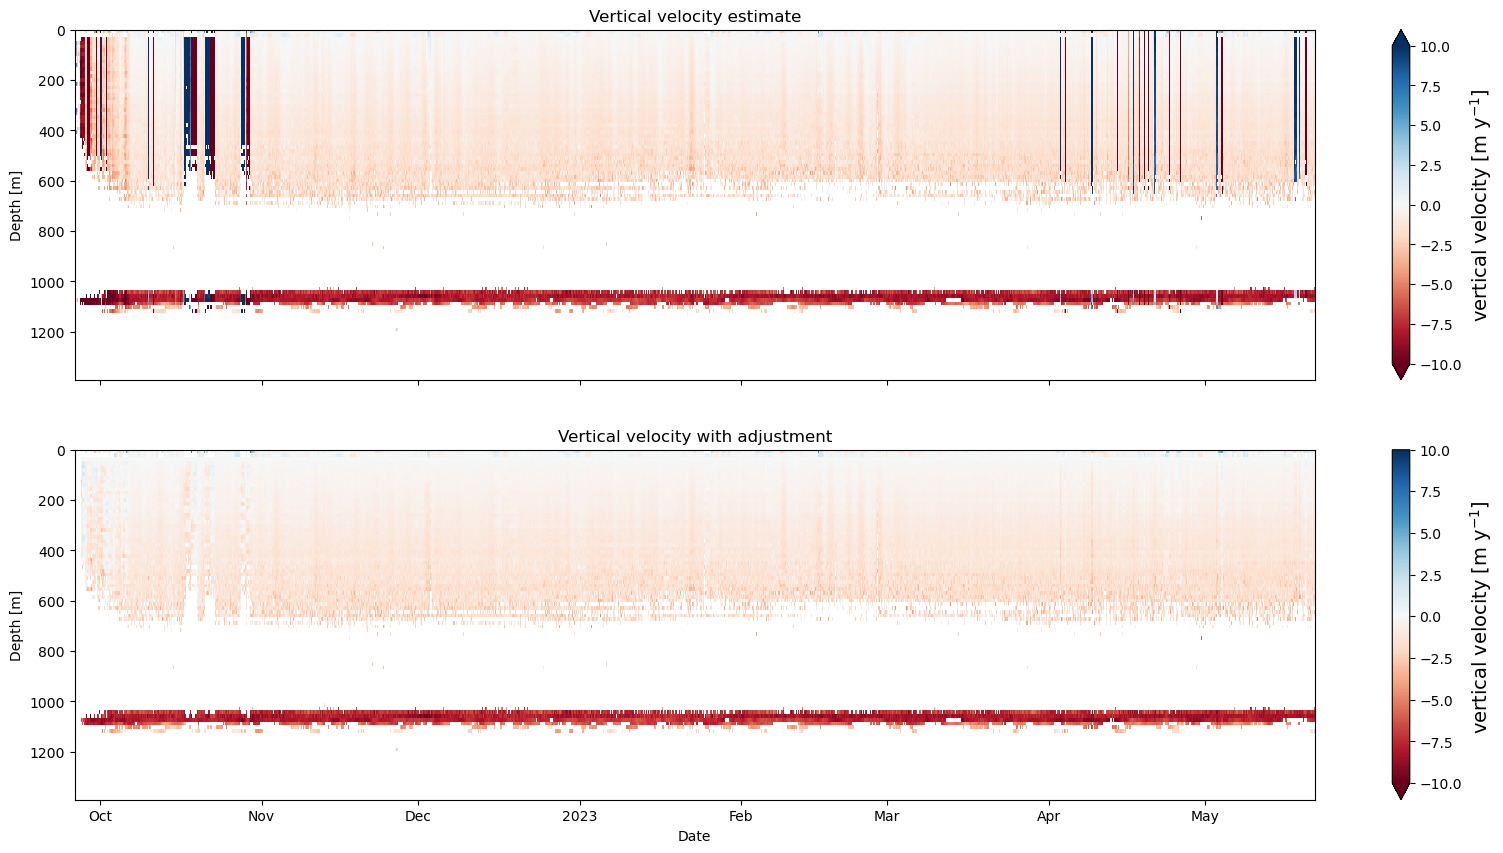

In [6]:
plot_vv_2d(a11_winter)

## Summer

In [7]:
time_to_interp = pd.date_range("2022-05-27 12:00", "2022-09-25 12:00", freq="15min")
interp_profiles = s22.interp(time=time_to_interp,method='linear')

In [8]:
a11_summer = strain_metrics(interp_profiles,40, 40,48,700)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


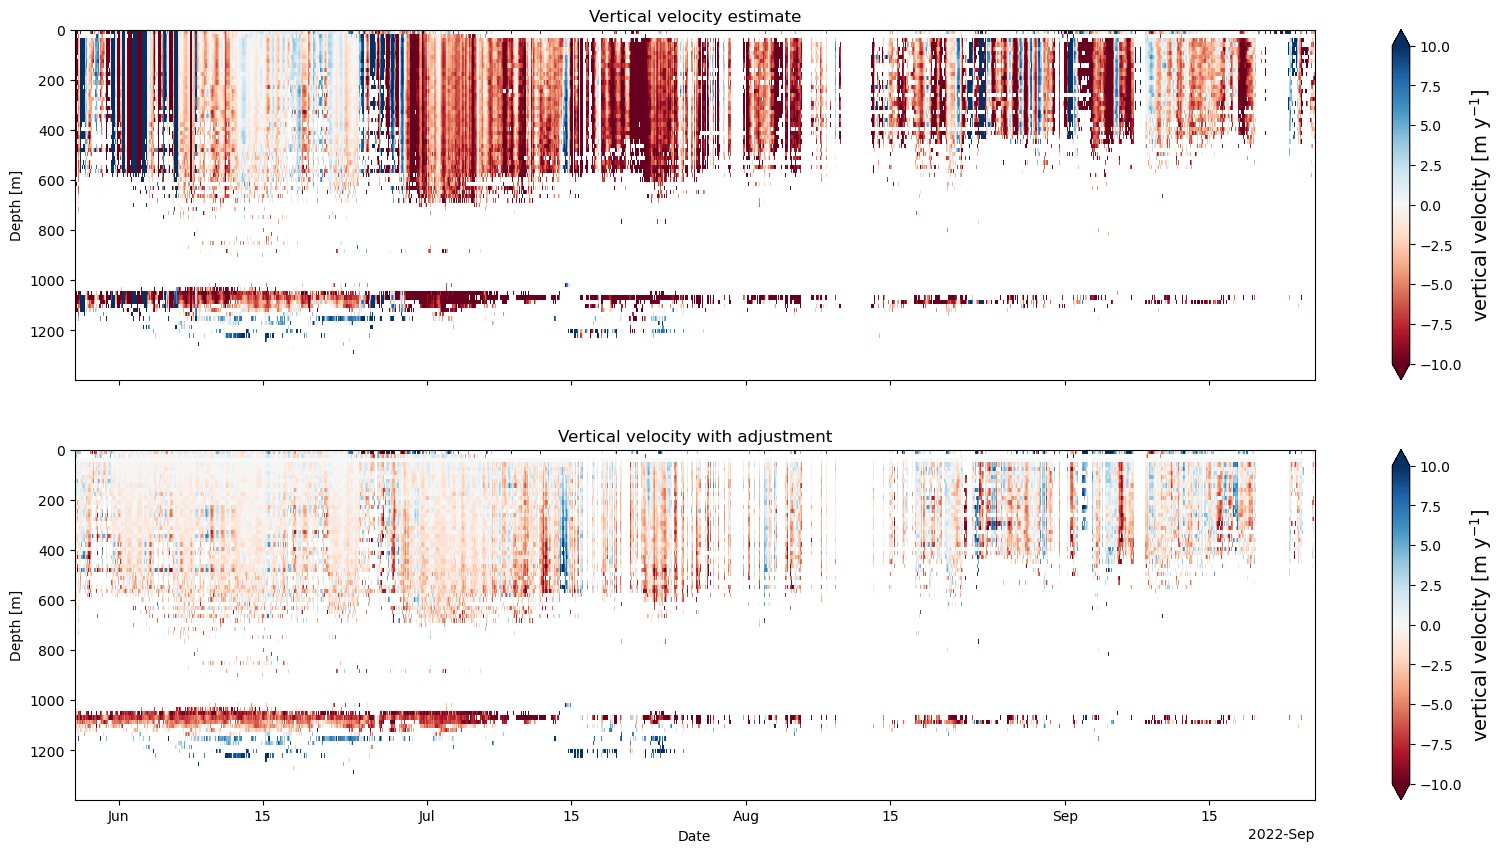

In [9]:
plot_vv_2d(a11_summer)

# Sanity Check

I will introduce an artificial phase change to some clean data and see if that impacts the results. I will also see if I can remove it. First I want to see if the phase change across the entire data changes anything

In [10]:
time_to_interp = pd.date_range("2023-01-01 00:00", "2023-01-10 00:00", freq="15min")
test_snippet = winter.interp(time=time_to_interp,method='linear')

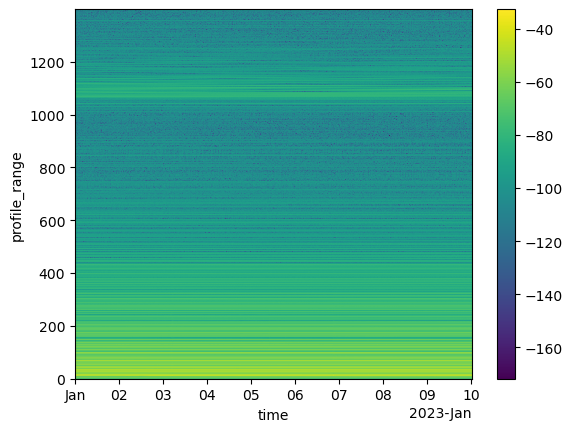

In [11]:
xa.dB(test_snippet).plot(x='time')

In [12]:
a11_winter = strain_metrics(test_snippet, 70, 70,96,600)

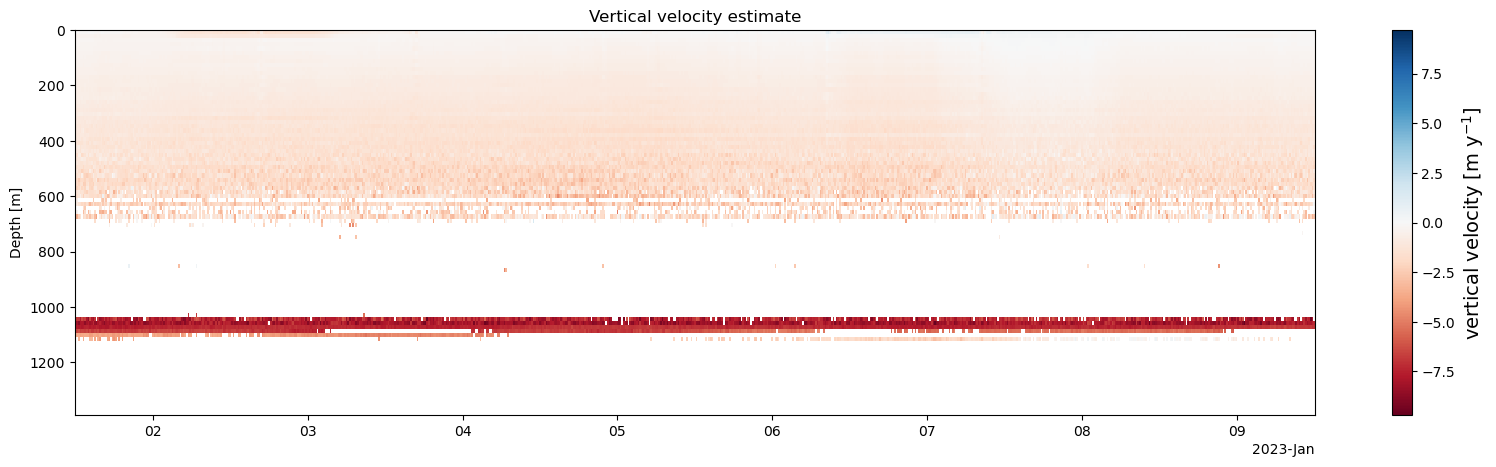

In [13]:
fig, axs = plt.subplots(figsize=(20,5),nrows=1)
plt1 = a11_winter.vv.plot(ax=axs,x='time',cmap='RdBu')
axs.invert_yaxis()
axs.set_title('Vertical velocity estimate')
axs.set_xlabel('')
plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



Now let's introduce a phase change. Make a 1cm shift away from reflectors at depths below 25 m. 

In [14]:
import cmath

def range2phase(ds,r):
    centre_freq = ds.attrs['centre_freq']
    c_ice = 1.6823e8 
    lambda_c = c_ice/centre_freq
    phi = r*4.*np.pi/lambda_c
    return cmath.exp(1j*phi)


In [15]:
test_snippet_artifact = test_snippet.where(test_snippet.profile_range < 25, (test_snippet*range2phase(winter,0.01)))

In [16]:
test_snippet_step = xr.concat([test_snippet.isel(time=range(400)),test_snippet_artifact.isel(time=range(400,len(test_snippet_artifact)))],dim='time')

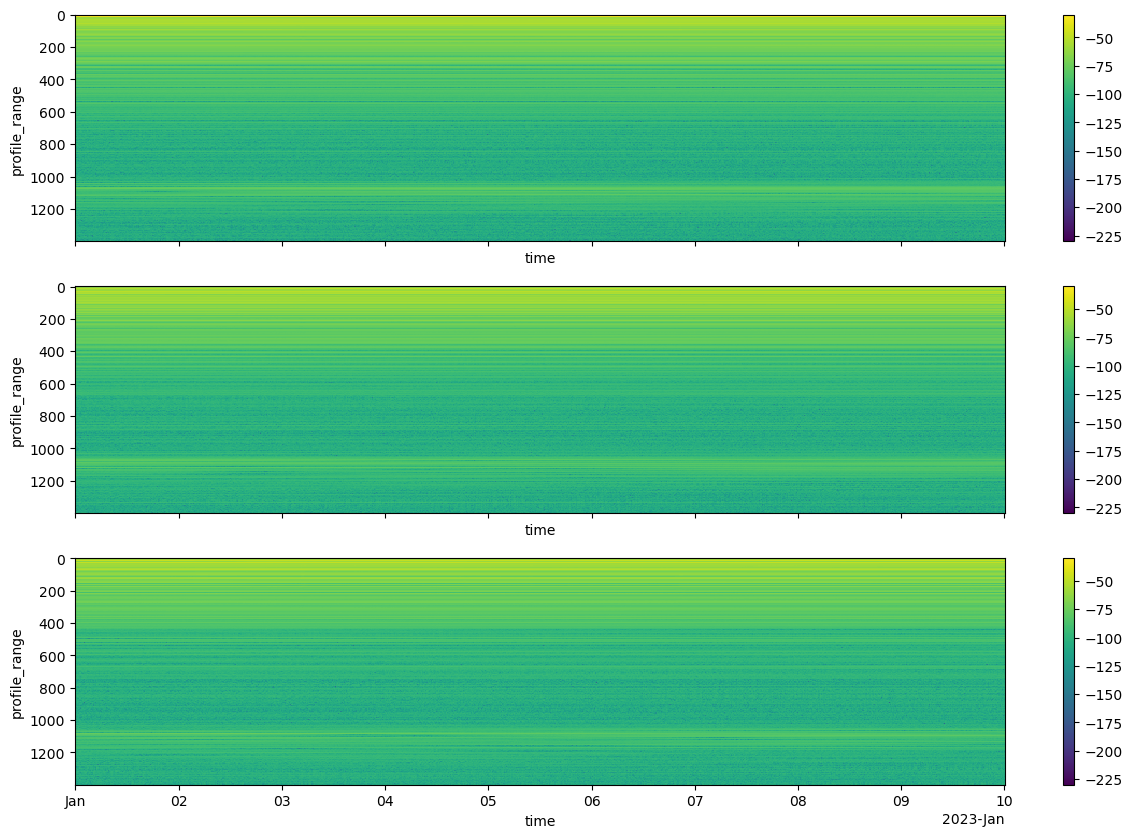

In [17]:
fig, axs = plt.subplots(nrows = 3, figsize=(15,10),sharex=True,sharey=True)
xa.dB(test_snippet).plot(ax=axs[0],x='time',vmin=-230,vmax=-30)
axs[0].invert_yaxis()
#axs[0].set_ylim([200,0])
xa.dB(test_snippet_artifact).plot(ax=axs[1],x='time',vmin=-230,vmax=-30)
axs[1].invert_yaxis()
#axs[1].set_ylim([200,0])
xa.dB(test_snippet_step).plot(ax=axs[2],x='time',vmin=-230,vmax=-30)
axs[1].invert_yaxis()
#axs[1].set_ylim([200,0])


In [18]:
a11 = strain_metrics(test_snippet, 70, 70,96,600)
a11_artifact = strain_metrics(test_snippet_artifact, 70, 70,96,600)
a11_step = strain_metrics(test_snippet_step, 70, 70,96,600)

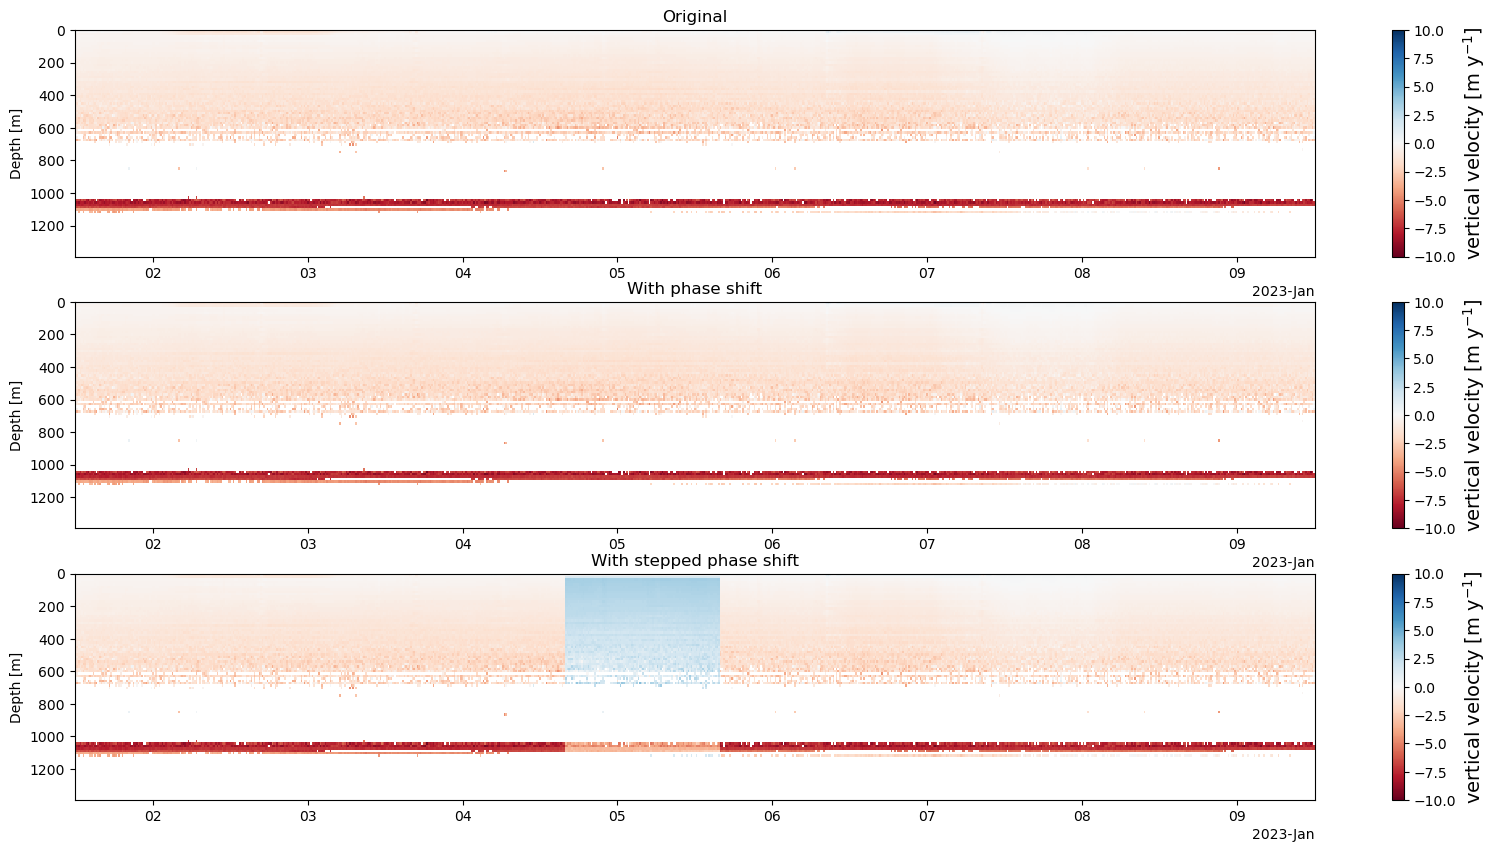

In [19]:
fig, axs = plt.subplots(figsize=(20,10),nrows=3)
plt1 = a11.vv.plot(ax=axs[0],x='time',cmap='RdBu',vmin=-10,vmax=10)
axs[0].invert_yaxis()
axs[0].set_title('Original')
axs[0].set_xlabel('')
plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

plt2 = a11_artifact.vv.plot(ax=axs[1],x='time',cmap='RdBu',vmin=-10,vmax=10)
axs[1].invert_yaxis()
axs[1].set_title('With phase shift')
axs[1].set_xlabel('')
plt2.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

plt2 = a11_step.vv.plot(ax=axs[2],x='time',cmap='RdBu',vmin=-10,vmax=10)
axs[2].invert_yaxis()
axs[2].set_title('With stepped phase shift')
axs[2].set_xlabel('')
plt2.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



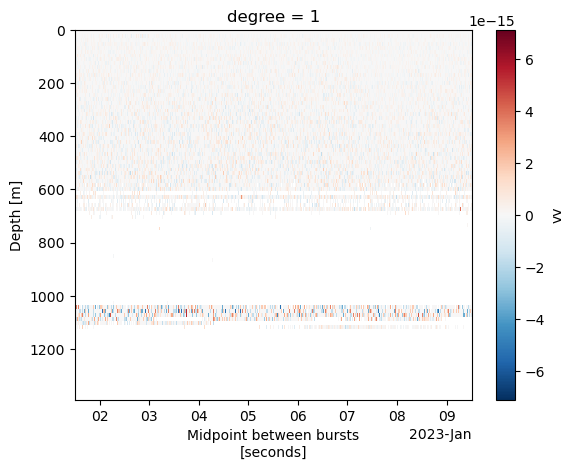

In [20]:
# difference between with or without phase shift
diff  = a11 - a11_artifact
diff.vv.plot(x='time')
plt.gca().invert_yaxis()

So when everything is shifted, the vertical velocities are actually fine, within the shifted part. Now, let's see if we can correct for the shift itself.

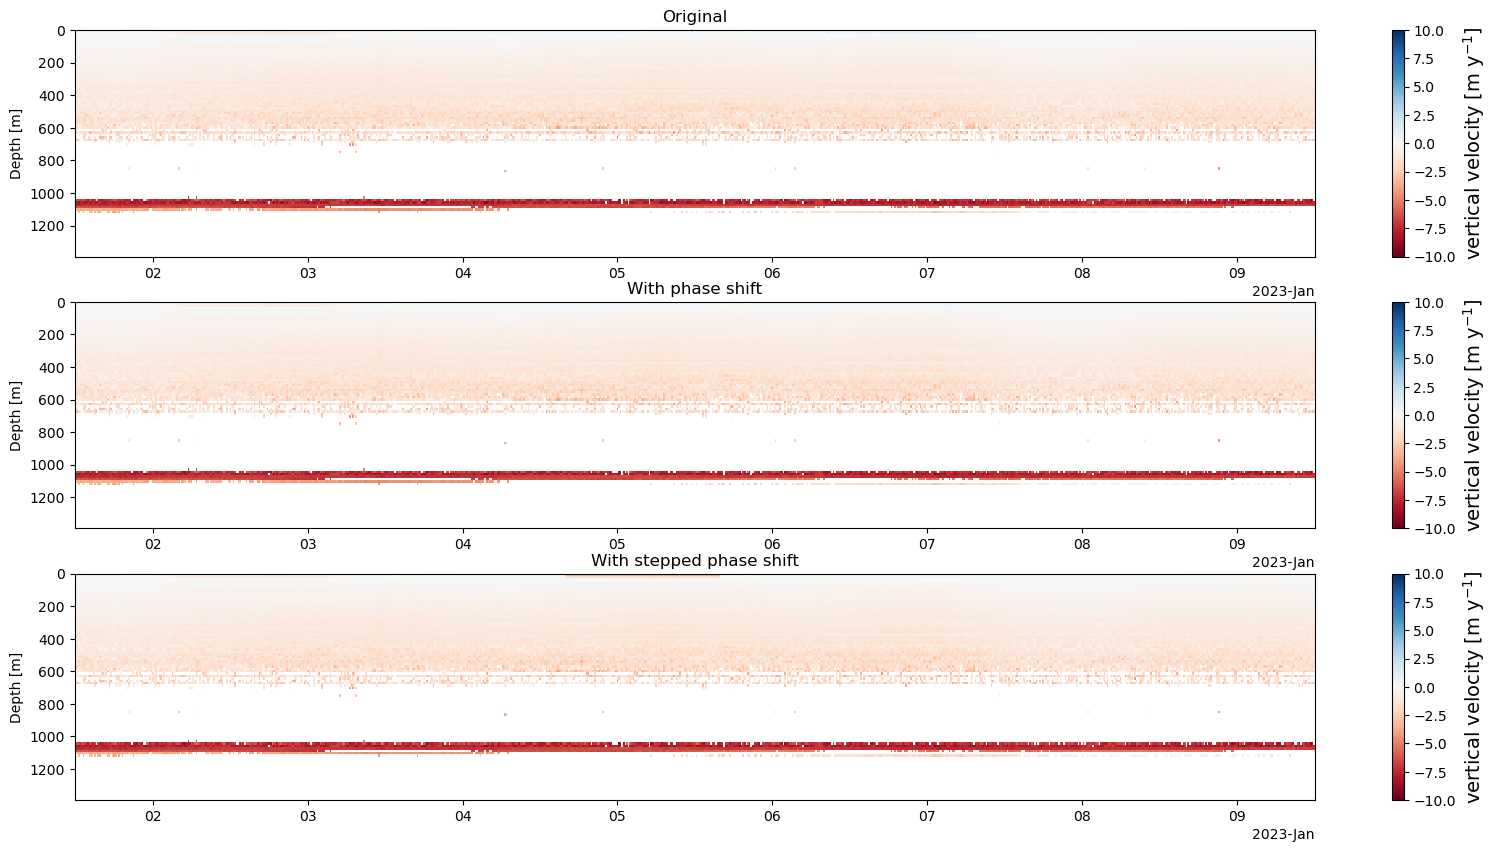

In [21]:
fig, axs = plt.subplots(figsize=(20,10),nrows=3)
plt1 = a11.vv_adjust.plot(ax=axs[0],x='time',cmap='RdBu',vmin=-10,vmax=10)
axs[0].invert_yaxis()
axs[0].set_title('Original')
axs[0].set_xlabel('')
plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

plt2 = a11_artifact.vv_adjust.plot(ax=axs[1],x='time',cmap='RdBu',vmin=-10,vmax=10)
axs[1].invert_yaxis()
axs[1].set_title('With phase shift')
axs[1].set_xlabel('')
plt2.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

plt2 = a11_step.vv_adjust.plot(ax=axs[2],x='time',cmap='RdBu',vmin=-10,vmax=10)
axs[2].invert_yaxis()
axs[2].set_title('With stepped phase shift')
axs[2].set_xlabel('')
plt2.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



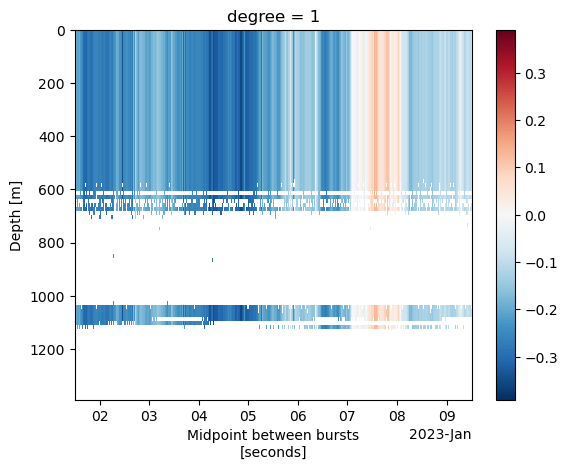

In [22]:
(a11.vv-a11.vv_adjust).plot(x='time')
plt.gca().invert_yaxis()

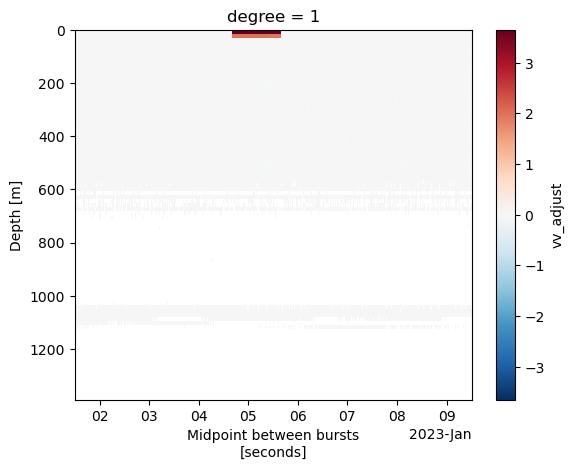

In [23]:
(a11.vv_adjust-a11_step.vv_adjust).plot(x='time')
plt.gca().invert_yaxis()

Seems like there is a slight divergence. Perhaps I'm using too large a window. I should use right where the brightest reflector is and the region below.

## Checking if displacement amplitudes due to surface changes are indeed constant

In [24]:
time_to_interp = pd.date_range("2022-10-27 0:00", "2022-10-31 0:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')


(200.0, 0.0)

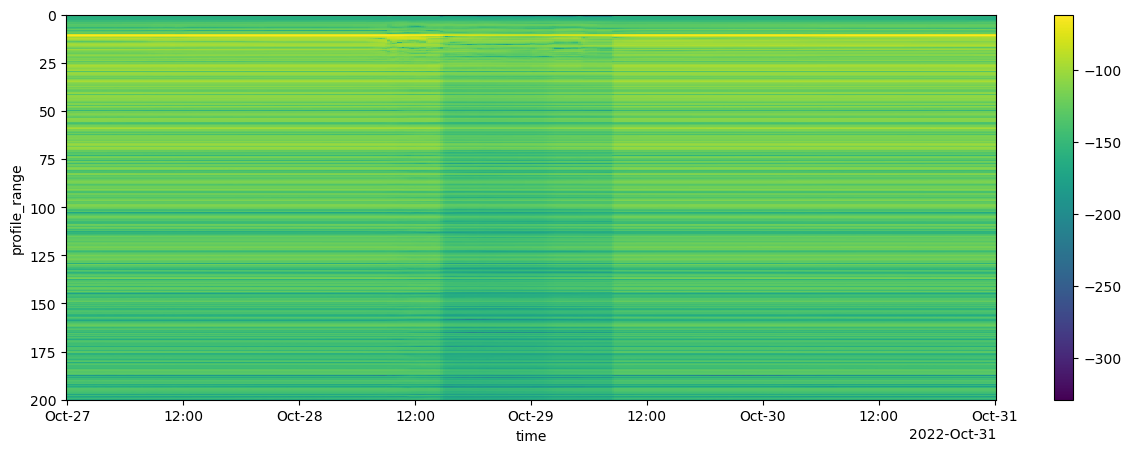

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(abs(interp_profiles)**2).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)
plt.ylim([200,0])

In [26]:
vv_step = strain_metrics(interp_profiles, 70, 70,96,600)


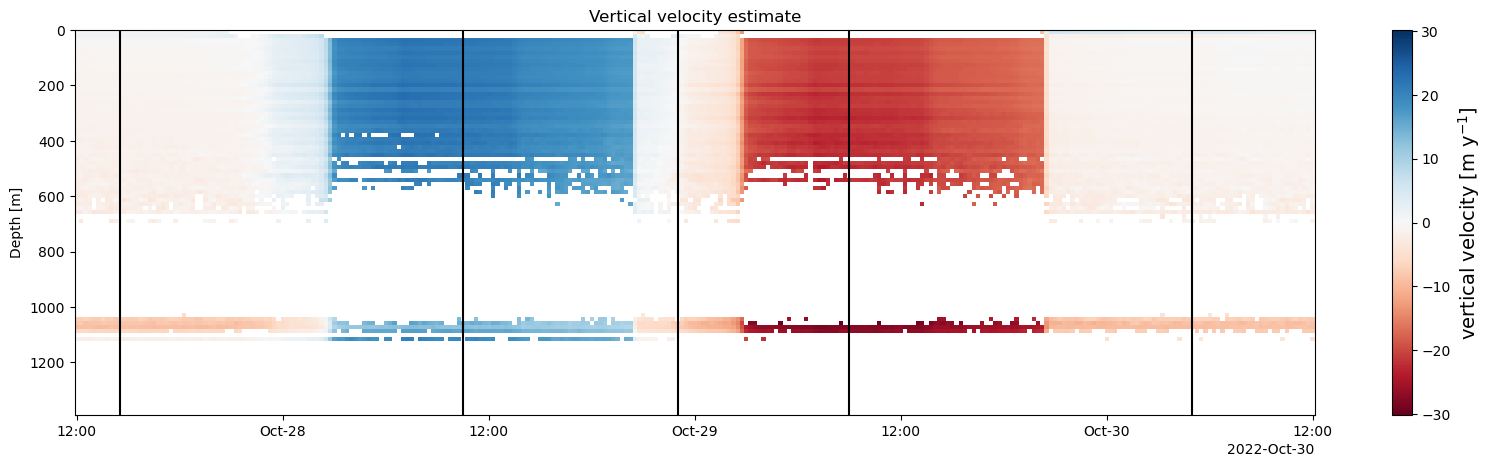

In [27]:
fig, axs = plt.subplots(figsize=(20,5),nrows=1)
plt1 = vv_step.vv.plot(ax=axs,x='time',cmap='RdBu')
axs.invert_yaxis()
axs.set_title('Vertical velocity estimate')
axs.set_xlabel('')
axs.axvline(vv_step.isel(time=[10]).time,color='k')
axs.axvline(vv_step.isel(time=[90]).time,color='k')
axs.axvline(vv_step.isel(time=[140]).time,color='k')
axs.axvline(vv_step.isel(time=[180]).time,color='k')
axs.axvline(vv_step.isel(time=[260]).time,color='k')

#plt.ylim([200,0])

plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



We see that with a day lag, some of the signal becomes less coherent due to the large apparent displacement. Notably near the surface <25 m in depth (i.e. around the top 10 m of ice), and farther down in depth. Let's look at the mean velicities during the above time slices

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

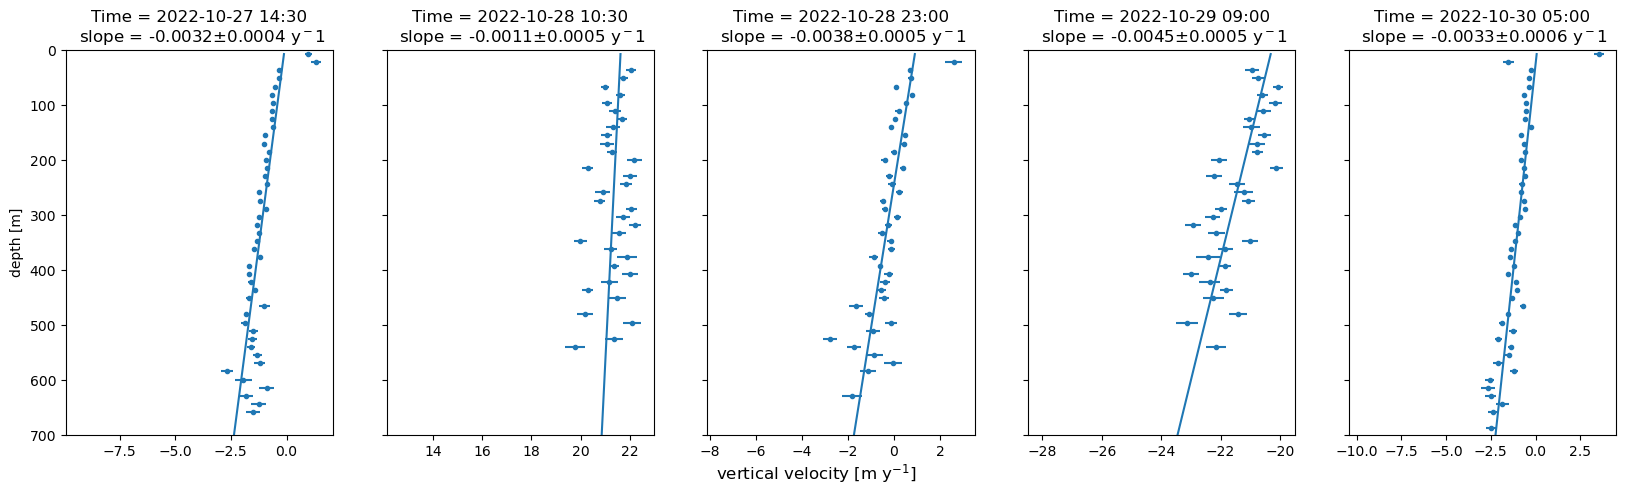

In [28]:
fig, axs = plt.subplots(figsize=(20,5),ncols=5,sharey=True)
time_inds = [10,90,140,180,260]
for i in range(5):
    axs[i].errorbar(vv_step.vv.isel(time=time_inds[i]),vv_step.profile_range,yerr=None,xerr=vv_step.err.isel(time=time_inds[i]),linestyle='None',marker='.',color = 'tab:blue')
    axs[i].plot(vv_step.fit.isel(time=time_inds[i]),vv_step.profile_range)
    axs[i].invert_yaxis()
    title_str = str(vv_step.time.values[time_inds[i]])[:16].replace('T',' ')
    axs[i].set_title(f'Time = {title_str}\n slope = {vv_step.isel(time=time_inds[i]).slope.values:.2}$\pm${vv_step.isel(time=time_inds[i]).slope_err.values:.1} y$^{-1}$')
    axs[i].set_ylim([700,0])
    #axs[i].set_xlim([-24,24])
    
axs[0].set_ylabel('depth [m]')
fig.supxlabel('vertical velocity [m y$^{-1}$]')

During the steps, there is some variation in the slopes unfortunately. However, it is very obvious that the entire signal has been shifted. 

Let's try with subtler swings

In [29]:
time_to_interp = pd.date_range("2023-04-10 6:00", "2023-04-12 6:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')


(200.0, 0.0)

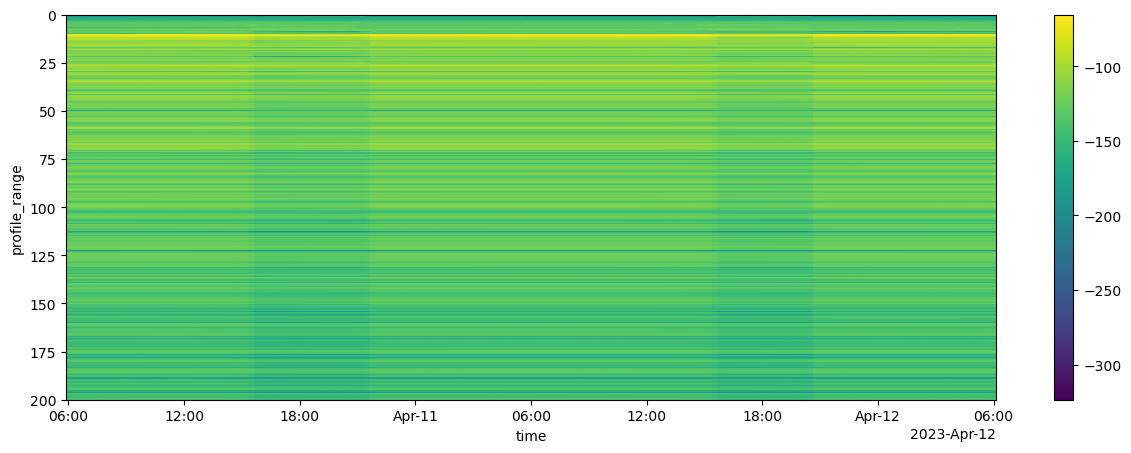

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(abs(interp_profiles)**2).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)
plt.ylim([200,0])

In [31]:
vv_step = strain_metrics(interp_profiles, 70, 70,24,600)
# used smaller window

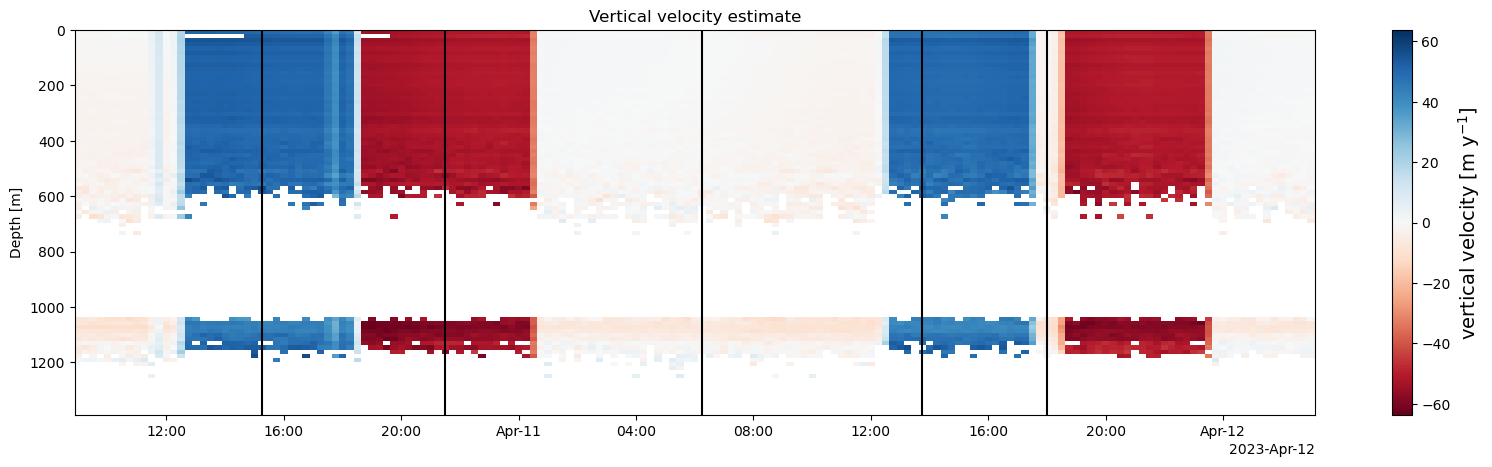

In [32]:
fig, axs = plt.subplots(figsize=(20,5),nrows=1)
plt1 = vv_step.vv.plot(ax=axs,x='time',cmap='RdBu')
axs.invert_yaxis()
axs.set_title('Vertical velocity estimate')
axs.set_xlabel('')
axs.axvline(vv_step.isel(time=[25]).time,color='k')
axs.axvline(vv_step.isel(time=[50]).time,color='k')
axs.axvline(vv_step.isel(time=[85]).time,color='k')
axs.axvline(vv_step.isel(time=[115]).time,color='k')
axs.axvline(vv_step.isel(time=[132]).time,color='k')

#plt.ylim([200,0])

plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

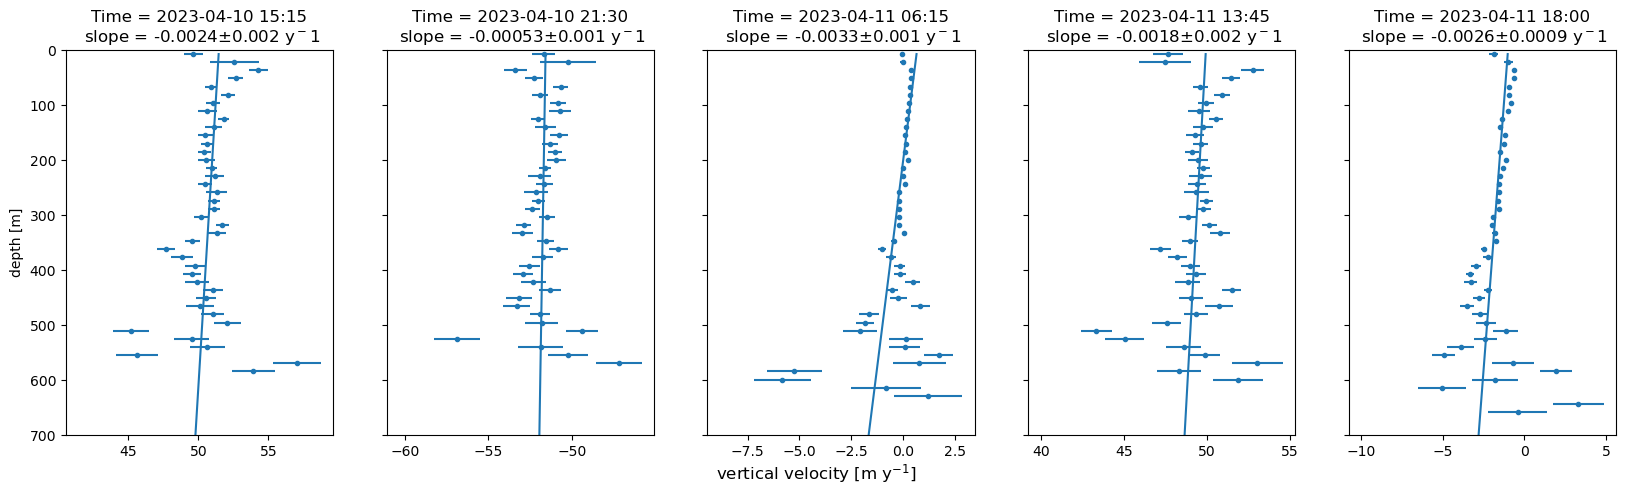

In [33]:
fig, axs = plt.subplots(figsize=(20,5),ncols=5,sharey=True)
time_inds = [25,50,85,115,132]
for i in range(5):
    axs[i].errorbar(vv_step.vv.isel(time=time_inds[i]),vv_step.profile_range,yerr=None,xerr=vv_step.err.isel(time=time_inds[i]),linestyle='None',marker='.',color = 'tab:blue')
    axs[i].plot(vv_step.fit.isel(time=time_inds[i]),vv_step.profile_range)
    axs[i].invert_yaxis()
    title_str = str(vv_step.time.values[time_inds[i]])[:16].replace('T',' ')
    axs[i].set_title(f'Time = {title_str}\n slope = {vv_step.isel(time=time_inds[i]).slope.values:.2}$\pm${vv_step.isel(time=time_inds[i]).slope_err.values:.1} y$^{-1}$')
    axs[i].set_ylim([700,0])
    #axs[i].set_xlim([-55,55])
    
axs[0].set_ylabel('depth [m]')
fig.supxlabel('vertical velocity [m y$^{-1}$]')

The slopes are still quite different. Though we are using a more sensitive calculation

Let's try with "clean" data

In [43]:
#time_to_interp = pd.date_range("2022-10-20 0:00", "2022-10-30 0:00", freq="15min")
time_to_interp = pd.date_range("2023-03-20 0:00", "2023-03-30 0:00", freq="15min")
#time_to_interp = pd.date_range("2023-03-27 0:00", "2023-03-28 12:00", freq="15min")

interp_profiles = winter.interp(time=time_to_interp,method='linear')


(200.0, 0.0)

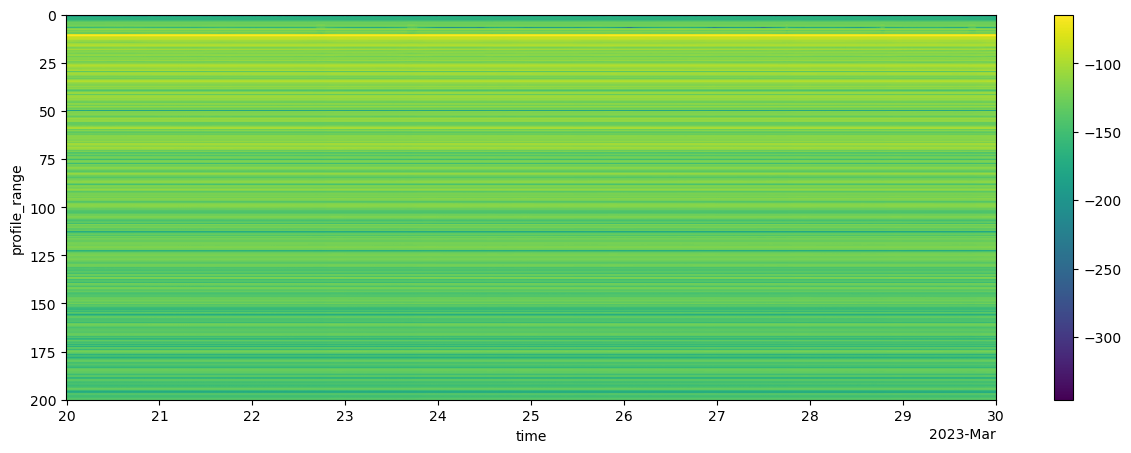

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(abs(interp_profiles)**2).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)
plt.ylim([200,0])

In [36]:
vv_step = strain_metrics(interp_profiles, 70, 70,96,600)
# used smaller window

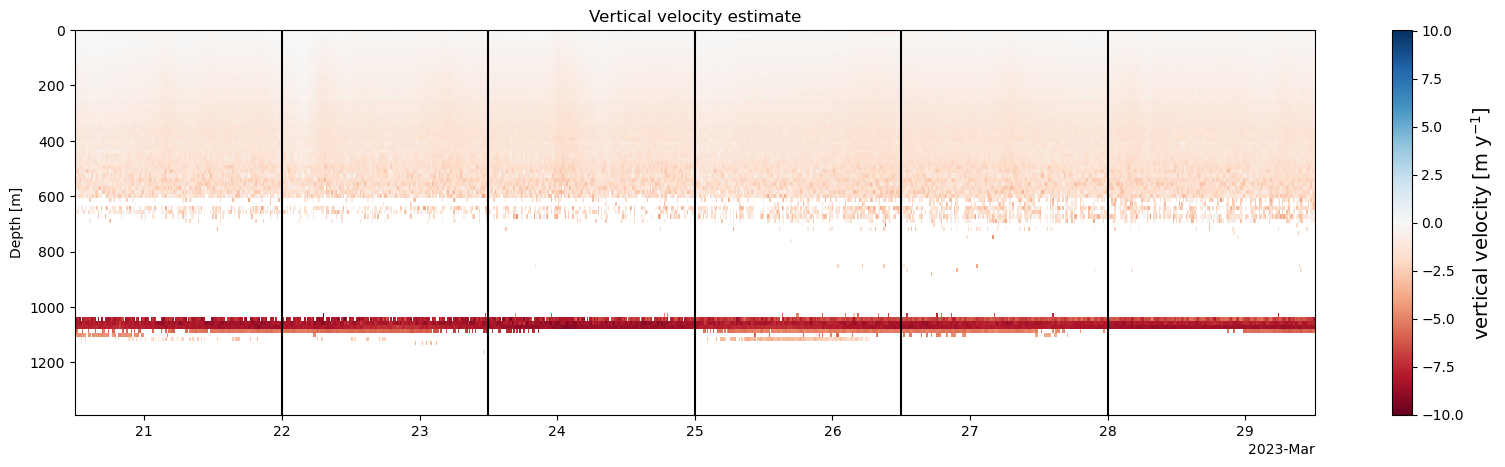

In [37]:
fig, axs = plt.subplots(figsize=(20,5),nrows=1)
plt1 = vv_step.vv.plot(ax=axs,x='time',cmap='RdBu')
axs.invert_yaxis()
axs.set_title('Vertical velocity estimate')
axs.set_xlabel('')
for i in range(1,6):
    axs.axvline(vv_step.isel(time=[i*len(vv_step.time)//6]).time,color='k')
   

#plt.ylim([200,0])

plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

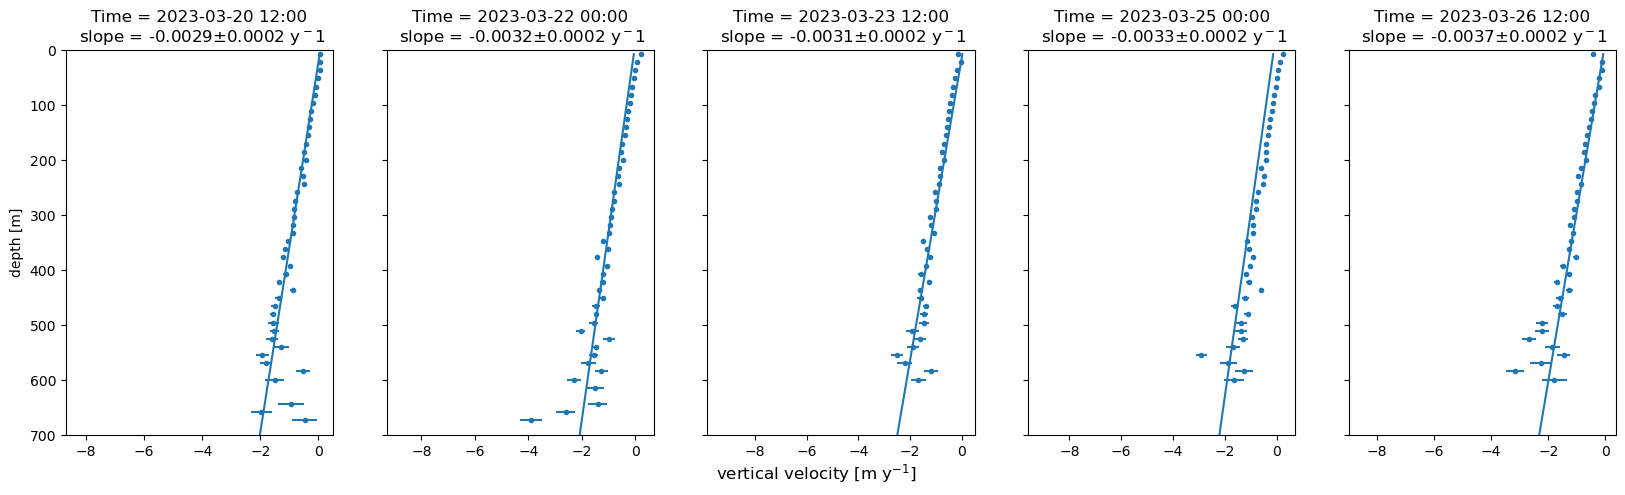

In [38]:
fig, axs = plt.subplots(figsize=(20,5),ncols=5,sharey=True)
for i in range(5):
    axs[i].errorbar(vv_step.vv.isel(time=i*len(vv_step.time)//6),vv_step.profile_range,yerr=None,xerr=vv_step.err.isel(time=i*len(vv_step.time)//6),linestyle='None',marker='.',color = 'tab:blue')
    axs[i].plot(vv_step.fit.isel(time=time_inds[i]),vv_step.profile_range)
    axs[i].invert_yaxis()
    title_str = str(vv_step.time.values[i*len(vv_step.time)//6])[:16].replace('T',' ')
    axs[i].set_title(f'Time = {title_str}\n slope = {vv_step.isel(time=i*len(vv_step.time)//6).slope.values:.2}$\pm${vv_step.isel(time=i*len(vv_step.time)//6).slope_err.values:.1} y$^{-1}$')
    axs[i].set_ylim([700,0])
    #axs[i].set_ylim([100,0])

    #axs[i].set_xlim([-55,55])
    #axs[i].set_xlim([-1,1])
    
axs[0].set_ylabel('depth [m]')
fig.supxlabel('vertical velocity [m y$^{-1}$]')

A lot more clean and consistent. This leads me to wonder how the strain rate relates to amplitude change

In [55]:
time_to_interp = pd.date_range("2022-10-20 6:00", "2022-10-30 6:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')


(200.0, 0.0)

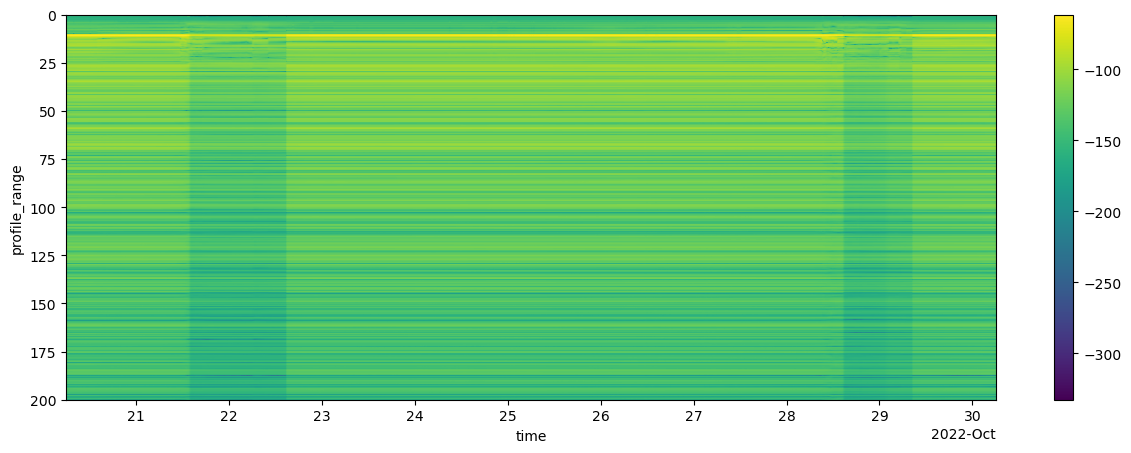

In [56]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(abs(interp_profiles)**2).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)
plt.ylim([200,0])

In [57]:
vv_step = strain_metrics(interp_profiles, 70, 70,24,600)
# used smaller window

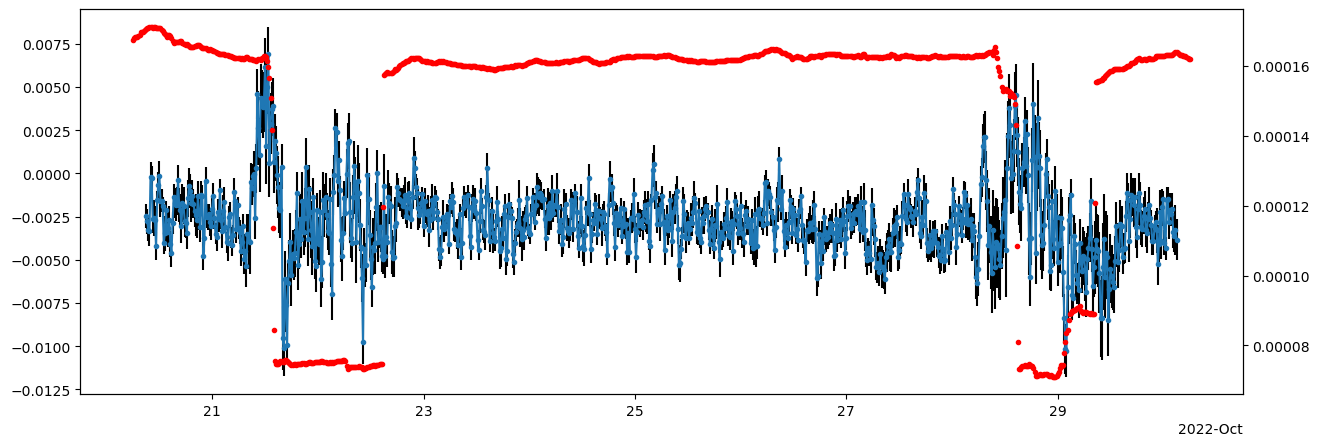

In [58]:
fig, ax = plt.subplots(figsize=(15,5))
ax.errorbar(vv_step.time.values,vv_step.slope,yerr=vv_step.slope_err,marker='.',ecolor='k')
ax1 = ax.twinx()
abs(interp_profiles).mean(dim='profile_range').plot(ax=ax1,color='r',linestyle='None',marker='.')


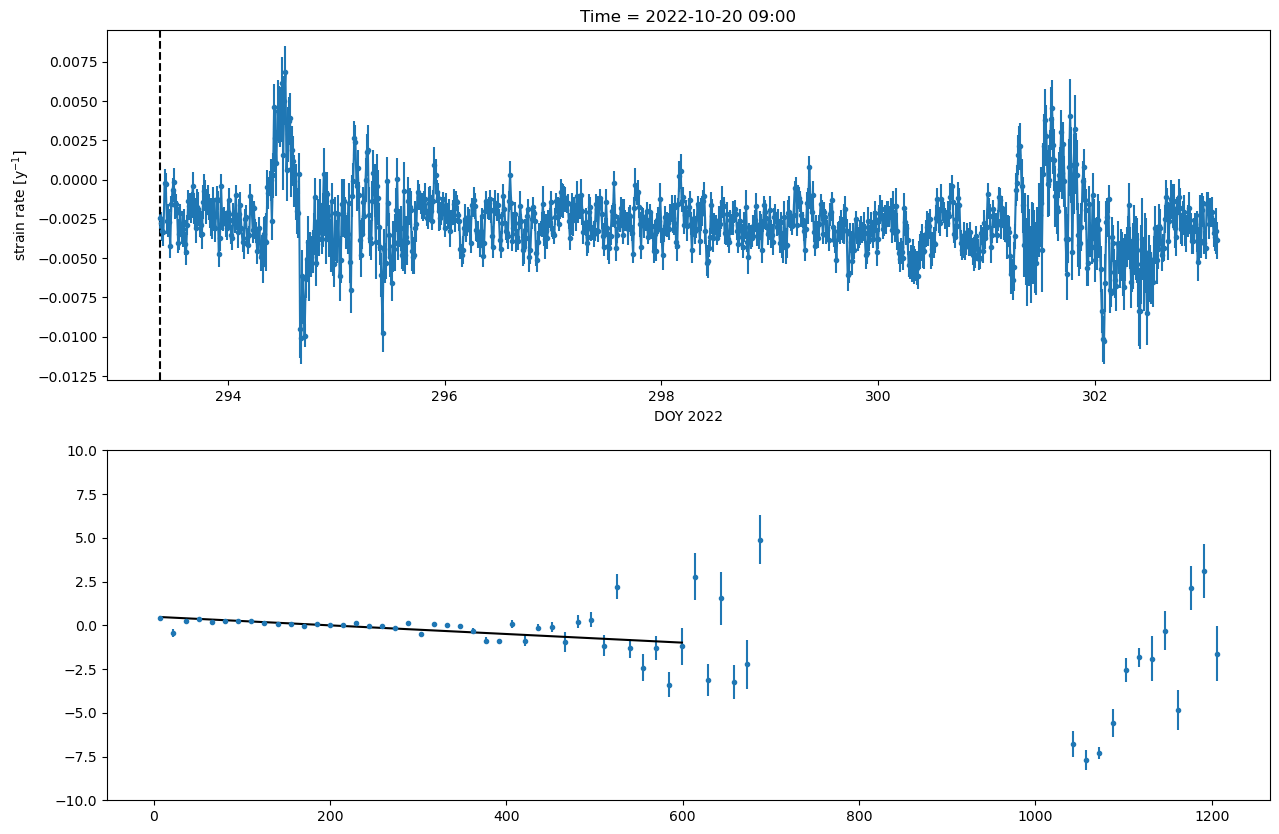

In [59]:
# ok it looks like the oscillations are due to a fitting  artifact
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np


fig,axs = plt.subplots(figsize=(15, 10),nrows = 2)


times = vv_step.doy_decimal.values
a11_strain = axs[0].errorbar(vv_step.doy_decimal,vv_step.slope,yerr=vv_step.slope_err,marker='.',label='A11')

#ax4.set_yscale('symlog', linthresh=0.1)
axs[0].set_xlabel('DOY 2022')
axs[0].set_ylabel('strain rate [y$^{-1}$]')
time_line = axs[0].axvline(times[0],color = 'black',linestyle = '--')
title_str = str(vv_step.time.values[0])[:16].replace('T',' ')
axs[0].set_title(f'Time = {title_str}')


axs[1].errorbar(vv_step.profile_range,vv_step.vv.isel(time=0),yerr=vv_step.err.isel(time=0),linestyle='None',marker='.',color = 'tab:blue')
axs[1].plot(vv_step.profile_range.where(vv_step.profile_range<600),vv_step.fit.isel(time=0).where(vv_step.profile_range<600),color='k')
axs[1].set_ylim([-10,10])

def animate(i):
    i = 10*i
    time_line.set_xdata([times[i],times[i]])
    title_str = str(vv_step.time.values[i])[:16].replace('T',' ')
    axs[0].set_title(f'Time = {title_str}')
    
    axs[1].clear()
    axs[1].errorbar(vv_step.profile_range,vv_step.vv.isel(time=i),yerr=vv_step.err.isel(time=i),linestyle='None',marker='.',color = 'tab:blue')
    axs[1].plot(vv_step.profile_range.where(vv_step.profile_range<600),vv_step.fit.isel(time=i).where(vv_step.profile_range<600),color='k')

    axs[1].set_ylim([-10,10])


  

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(times)//10)

from IPython.display import HTML
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())


In [51]:
len(times)

937